In [1]:
import main as wng

In [2]:
import numpy as np

In [3]:
import pandas as pd
#from wingilya import WingsOfEvidence
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1 as axes_grid1
import matplotlib.colors as colors
%matplotlib inline

### Предобработка данных

In [5]:
train_data = pd.read_csv('tr_for_students.csv')


In [6]:
X_len = len(train_data)

Выделим атрибут дефолта в качестве целевого и удалим из выборки. Также удалим дату выдачи кредита issue_d как фактор модели.

In [7]:
X = train_data.copy()
Y = X['def'].copy()
X_dt = X['issue_d'].copy()
X.drop(['def', 'issue_d'],axis='columns', inplace=True)
drop_list = ['def', 'issue_d']
#X.drop(['def'],axis='columns', inplace=True)


#### Матрица корреляции

Построим таблицу корреляции датафрейма. Заметим, что у двух факторов крайне высокая корреляция: funded_amnt и installment. Действительно, величина ежемесячного платежа должна коррелировать с величиной кредита. 
Следует исключить один из этих факторов данной модели. Для того, чтобы принять решение, воспользуемся мерой information value (IV), однако, рассчитаем её позднее, после woe-преобразования.

In [8]:
train_data.corr()

,installment,dti,funded_amnt,annual_inc,emp_length,term,inq_last_6mths,mths_since_recent_inq,delinq_2yrs,chargeoff_within_12_mths,num_accts_ever_120_pd,num_tl_90g_dpd_24m,acc_open_past_24mths,avg_cur_bal,tot_hi_cred_lim,delinq_amnt,def
installment,1.000000,0.056377,0.955046,0.399808,0.104872,0.159262,0.017165,-0.003792,0.023248,0.010027,-0.041071,-0.008303,0.010593,0.216314,0.307664,0.000773,0.030775
dti,0.056377,1.000000,0.060513,-0.194074,0.048752,0.073554,0.006010,0.007946,-0.017359,-0.008308,-0.068050,-0.036795,0.161402,-0.126158,0.004057,-0.000257,0.074369
funded_amnt,0.955046,0.060513,1.000000,0.402160,0.120359,0.402883,0.000991,0.016723,0.013907,0.006964,-0.051299,-0.013087,0.000411,0.244885,0.341130,0.002334,0.052149
annual_inc,0.399808,-0.194074,0.402160,1.000000,0.075258,0.087205,0.076298,-0.051792,0.072400,0.019257,0.046875,0.030211,0.059436,0.434608,0.568726,0.006740,-0.054393
emp_length,0.104872,0.048752,0.120359,0.075258,1.000000,0.076698,-0.007528,0.010349,0.031344,0.013242,0.020820,0.004395,-0.001132,0.079997,0.093797,0.004545,-0.001309
term,0.159262,0.073554,0.402883,0.087205,0.076698,1.000000,0.042081,-0.020409,0.013092,0.003195,-0.013738,-0.002632,0.036272,0.096006,0.121757,0.008199,0.153506
inq_last_6mths,0.017165,0.006010,0.000991,0.076298,-0.007528,0.042081,1.000000,-0.672445,0.026510,0.002999,0.052619,0.026754,0.215838,0.038513,0.085460,0.001023,0.061401
mths_since_recent_inq,-0.003792,0.007946,0.016723,-0.051792,0.010349,-0.020409,-0.672445,1.000000,-0.023794,-0.003197,-0.051778,-0.020254,-0.158600,-0.017562,-0.050295,-0.000851,-0.049855
delinq_2yrs,0.023248,-0.017359,0.013907,0.072400,0.031344,0.013092,0.026510,-0.023794,1.000000,0.127960,0.238493,0.641828,-0.066146,0.069718,0.085038,0.037673,0.010025
chargeoff_within_12_mths,0.010027,-0.008308,0.006964,0.019257,0.013242,0.003195,0.002999,-0.003197,0.127960,1.000000,0.139994,0.199679,-0.011922,0.012840,0.009557,0.015637,-0.007979


#### Анализ количества уникальных значений

Также, был проведён анализ количества уникальных значений (не приведён здесь полностью). По итогу анализа факторы delinq_amnt и chargeoff_within_12_mths было решено исключить из датасета. Более 99% измерений по данным атрибутам попадут в один бакет, поэтому некорректно оценивать влияние этих факторов на попадание в дефолт.

In [9]:
X.groupby(X['delinq_amnt'].apply(lambda z: 1 if z>0 else 0)).size().sort_values(ascending=False)/X_len

delinq_amnt
0    0.997924
1    0.002076
dtype: float64

In [10]:
X.groupby(['chargeoff_within_12_mths']).size().sort_values(ascending=False)/X_len

chargeoff_within_12_mths
0    0.994294
1    0.005019
2    0.000621
3    0.000065
dtype: float64

In [11]:
X.drop(['delinq_amnt', 'chargeoff_within_12_mths'],axis='columns', inplace=True)
drop_list.extend(['delinq_amnt', 'chargeoff_within_12_mths'])


Атрибут emp_title представляет из себя описание занимаемой должность заёмщика и, судя по всему, заполнено им вручную. Следовательно, атрибут имеет большой разброс уникальных значений. В теории предоставленный пакет для woe-преобразований объединяет редкие значения категориальных переменных в один бакет. Чтобы увеличить частоту отдельных значений emp_title, приведём всё к нижнему регистру, в остальном понадеемся на пакет woe =).

In [12]:
X['emp_title'] = X['emp_title'].str.lower()


#### Анализ NaN значений

По итогу анализа часть атрибутов имеют пропущенные значения: mths_since_recent_inq, num_accts_ever_120_pd, num_tl_90g_dpd_24m, acc_open_past_24mths, avg_cur_bal, tot_hi_cred_lim. 
При этом, судя по всему, пропуски в данных имеют некий системный характер: количество пропущенных значений практически у всех атрибутов совпадает, и у одних и тех же измерений не заполнена эта группа атрибутов.

Делать мы, в прочем, ничего с этим не будем. Предоставленный пакет sberbank-ai/wing обрабатывает NaN значения, относя их к отдельному bucket.

In [13]:
#совпадающие количества NaN значений
print(X['num_accts_ever_120_pd'].isnull().sum().sum())
print(X['num_tl_90g_dpd_24m'].isnull().sum().sum())

11941
11941


#### Преобразование woe с помощью пакета sberbank-ai/wing

Воспользуемся пакетом wing и рассчитаем оптимальные интервалы buckets для числовых переменных (и отнесение тех или иных значений категориальных переменных к их buckets). Также, пакет рассчитает для каждого измерения значение woe в зависимости от попадания в тот или иной bucket. 

In [14]:
wing = wng.WingsOfEvidence(bin_minimal_size=0.05, bin_size_increase=0.05, is_monotone=False)
wing.fit(X,Y)

WingsOfEvidence(bin_minimal_size=0.05, bin_size_increase=0.05,
        columns_to_apply=Index(['purpose', 'addr_state', 'sub_grade', 'home_ownership', 'emp_title',
       'installment', 'dti', 'funded_amnt', 'annual_inc', 'emp_length', 'term',
       'inq_last_6mths', 'mths_since_recent_inq', 'delinq_2yrs',
       'num_accts_ever_120_pd', 'num_tl_90g_dpd_24m', 'acc_open_past_24mths',
       'avg_cur_bal', 'tot_hi_cred_lim'],
      dtype='object'),
        is_monotone=False, mass_spec_values={}, n_initial=10, n_target=5,
        only_values=True, optimizer='ilya-binning', tree_random_state=None,
        verbose=False)

In [15]:
#woe-преобразование датафрейма
X_woe = wing.transform(X)
X_woe.head()


,WOE_purpose,WOE_addr_state,WOE_sub_grade,WOE_home_ownership,WOE_installment,WOE_dti,WOE_funded_amnt,WOE_annual_inc,WOE_emp_length,WOE_term,WOE_inq_last_6mths,WOE_mths_since_recent_inq,WOE_delinq_2yrs,WOE_num_accts_ever_120_pd,WOE_num_tl_90g_dpd_24m,WOE_acc_open_past_24mths,WOE_avg_cur_bal,WOE_tot_hi_cred_lim
0,-0.068905,-0.005393,-0.168085,-0.126515,0.271179,0.054686,0.076757,-0.336576,-0.019570,0.274275,-0.320899,0.171347,0.015971,-0.028647,-0.028647,0.028191,-0.028859,-0.028647
1,-0.068905,-0.154529,0.249938,0.112328,0.113647,0.054686,0.039107,0.221560,0.035729,0.274275,-0.082066,-0.077508,0.015971,0.030416,0.013430,-0.026698,0.275754,-0.012785
2,-0.068905,-0.005393,0.284280,-0.126515,-0.089846,0.075264,-0.283779,0.166500,0.059023,0.274275,0.168214,0.235561,0.015971,0.030416,0.013430,-0.114689,-0.078670,-0.177657
3,-0.068905,-0.005393,-0.075670,0.112328,-0.194083,0.075264,0.049867,-0.113341,0.035729,0.274275,-0.082066,-0.012151,-0.065687,-0.028450,-0.101414,0.105987,-0.050964,-0.144774
4,0.205866,0.167856,-0.193163,0.112328,0.036305,-0.235099,-0.014863,-0.141058,0.000460,0.274275,-0.320899,-0.012151,0.015971,0.030416,0.013430,-0.114689,-0.215696,0.017353


Стоит отметить, что emp_title пропал из датафрейма после woe-преобразование. Не раскопал в коде, однако, предполагаю, что в пакете есть ограничение на сильный разброс значений категоиральных переменных (или верхний порог самого частого значения). 
В теории, из emp_title можно извлечь семантическую составляющую с помощью Word2Vec, однако, необходимо будет векторы разделить в buckets. Так или иначе, это осталось на уровне идей, а emp_title также исключается из факторов модели.

In [16]:
drop_list.append('emp_title')


#### Анализ Information Value

Вернёмся к коррелирующим между собой атрибутам installment и funded_amnt. На данном этапе, когда экземлпяр класса WingsOfEvidence wing обучен на выборке, удобно сделать подсчёт Information Value для этих двух атрибутов. В пакете wing есть метод get_wing_agg(), предоставляющий простую статистику по атрибуту в разрезе buckets: подсчитанный woe, количество попаданий в дефолт (good), недефолт (bad), доля дефолтных значений (local_event_rate).
С помощью полученной сводной информации подсчитаем величину Information Value

In [17]:
def inf_val_by_agg(wing, Y, attr_name):
    #WingsOfEvidence содержит экземпляры класса WingOfEvidence на каждый атрибут модели.
    k = wing.fitted_wing[attr_name].get_wing_agg()
    #К сожалению, метод по дефолту get_wing_agg исключает из статистики bucket с NaN значениями,
    #а использование only_clear=False падает с ошибкой. Поэтому, костыльно посчитаем вручную статистику для NaN bucket-а.
    if wing.fitted_wing[attr_name].miss_woe['good']: #у атрибута есть пропущенные значения
        k_miss = wing.fitted_wing[attr_name].miss_woe
        k['good_distr'] = k['good']/(k['good'].sum() + k_miss['good']) #распределение дефолта в bucket
        k['bad_distr'] = k['bad']/(k['bad'].sum() + k_miss['bad']) #распределение недефолта в bucket
        k['IV_per_buck'] = (k['bad_distr'] - k['good_distr'])*k['woe']
        IV = k['IV_per_buck'].sum() + k_miss['woe']*(k_miss['bad']/(k['bad'].sum() + k_miss['bad']) - k_miss['good']/(k['good'].sum() + k_miss['good']))
    else:
        k['good_distr'] = k['good']/k['good'].sum()
        k['bad_distr'] = k['bad']/k['bad'].sum()
        k['IV_per_buck'] = (k['bad_distr'] - k['good_distr'])*k['woe']
        IV = k['IV_per_buck'].sum()
    return IV, k
    
#print(k['IV_per_buck'].sum())

In [18]:
#цикл для подсчёта Information Value всех факторов модели
features = X.columns.tolist()
features.remove('emp_title')
IV = []
for f in features:
    cur_IV, _ = inf_val_by_agg(wing, Y, f)
    IV.append(cur_IV)
features_stata = pd.DataFrame(pd.Series(features), columns = ['feature'])
features_stata['IV'] = pd.Series(IV)
features_stata.sort_values(['IV'], ascending = False)



,feature,IV
9,term,0.158135
2,sub_grade,0.085939
5,dti,0.046785
15,acc_open_past_24mths,0.041173
7,annual_inc,0.040329
16,avg_cur_bal,0.037655
10,inq_last_6mths,0.029989
6,funded_amnt,0.029132
17,tot_hi_cred_lim,0.029053
4,installment,0.028058


Как мы видим, у атрибута installment IV несколько ниже, нежели у funded_amnt, поэтому удалим его из модели. 

Стоит отметить, что все атрибуты с IV < 0.02 являются крайне слабыми предикторами модели и являются кандидатами на удаление. Однако, мы пока не будем этого делать, посмотрим на их вклад в коэффициент Джинни модели во время test 3.

In [19]:
X.drop(['installment'],axis='columns', inplace=True)
X_woe.drop(['WOE_installment'],axis='columns', inplace=True)
drop_list.append('installment')


#### Валидация модели

Обучим новый экземпляр класса WingsOfEvidence (поскольку изменился атрибутный состав датафрейма) и логрегрессор.

In [20]:
wing = wng.WingsOfEvidence(bin_minimal_size=0.05, bin_size_increase=0.05, is_monotone=False)
wing.fit(X,Y)


WingsOfEvidence(bin_minimal_size=0.05, bin_size_increase=0.05,
        columns_to_apply=Index(['purpose', 'addr_state', 'sub_grade', 'home_ownership', 'emp_title',
       'dti', 'funded_amnt', 'annual_inc', 'emp_length', 'term',
       'inq_last_6mths', 'mths_since_recent_inq', 'delinq_2yrs',
       'num_accts_ever_120_pd', 'num_tl_90g_dpd_24m', 'acc_open_past_24mths',
       'avg_cur_bal', 'tot_hi_cred_lim'],
      dtype='object'),
        is_monotone=False, mass_spec_values={}, n_initial=10, n_target=5,
        only_values=True, optimizer='ilya-binning', tree_random_state=None,
        verbose=False)

In [21]:
log = LogisticRegression()
log.fit(X_woe, Y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Загрузим валидационный набор данных, приведём к тому же виду, что и тренировочный. Проведём woe-преобразование и подсчитаем вероятность попадания к каждому из классов.

In [22]:
data_validate = pd.read_csv('vl_for_students.csv')


In [23]:
X_val = data_validate.copy()
Y_val = X_val['def'].copy()
X_val_dt = X_val['issue_d'].copy()
X_val.drop(drop_list,axis='columns', inplace=True)
X_val_woe = wing.transform(X_val)


In [24]:
val_proba = log.predict_proba(X_val_woe)


Переходим к проведению требуемых тестов.

### TEST 1

Для построения графика кривой Лоренца оцениваемой модели осуществим расчёт сумм кумулятивной доли дефолта при увеличении количества измерений. Выборка при этом отсортирована по PD по убыванию.

In [25]:
from scipy.interpolate import interp1d
from scipy.integrate import quad


In [26]:
PD = val_proba[:, 1]
default_data = pd.DataFrame(Y_val.copy())

#default_data - датафрейм с реальным и предсказанным значением дефолта. 
default_data.columns = ['actual']
default_data['predicted'] = pd.Series(PD.tolist())

#сортируем по убыванию PD
sorted_default_data = default_data.sort_values(by='predicted', ascending = False)


In [27]:
#расчёт накопленной доли реального дефолта с увеличением PD
len_val = len(default_data)
sorted_default_data['cumulative_actual'] = sorted_default_data['actual'].cumsum()/sorted_default_data['actual'].sum()
sorted_default_data = sorted_default_data.reset_index(drop=True)
sorted_default_data['cumulative_index'] = pd.Series(np.arange(1, len_val+1) / len_val)


[(0, 1),
 Text(0,0.5,'Кумулятивная доля истинных классов'),
 (0, 1),
 Text(0.5,0,'Кумулятивная доля объектов'),
 Text(0.5,1,'Коэффициент Джини')]

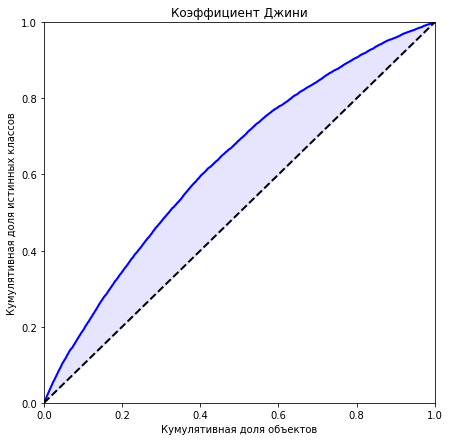

In [28]:
#построение графика, иллюстрирующего геометрический смысл коэффициента Джини. 
#Площадь под кривой равна значению ненормированного коэффициента Джини. 
#Отношение ненормированного коэффициента Джини к Джини идеальной модели дало бы искомый (нормированный) коэффициент Джини. 
x_values = [0] + list(sorted_default_data['cumulative_index'])
y_values = [0] + list(sorted_default_data['cumulative_actual'])

lorenze_curve = interp1d(x_values, y_values)
#вычисление площади, с которым не справилась библиотека scipy
#S_pred = quad(lor_curve, 0, 1, points=x_values)[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=1, sharey=True, figsize=(7, 7))
ax.plot(x_values, y_values, lw = 2, color = 'blue')
ax.fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
#ax[0].text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
ax.set(title='Коэффициент Джини', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))

Поскольку не удалось посчитать площадь, расчитаем Джини по известной формуле

In [29]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix,precision_score,recall_score,f1_score


In [30]:
rocauc = roc_auc_score(Y_val, PD)
gini = 2*rocauc - 1
print(rocauc, gini)


0.658953497094705 0.31790699418940993


Коэффициент Джини модели составил 31.7%  0.31783413216906165


Вернёмся к оценке information value и попробуем посмотреть, как повлияет исключение факторов с низким IV на коэффециент Джини модели.

In [31]:
drop_list_sv = drop_list.copy()
X_sv = X.copy()
X_woe_sv = X_woe.copy()
border = [0.01, 0.005, 0.004, 0.002, 0.001, 0] #пороги отсечения по IV
gini_bord = []
X_val_sv = X_val.copy()

In [32]:
for b in border:
    drop_list = drop_list_sv.copy()
    X = X_sv.copy()
    X_woe = X_woe_sv.copy()
    X_val = X_val_sv.copy()
    for f in features_stata.index: #если IV меньше текущего порога, исключаем из модели
        if features_stata['IV'][f]<b:
            drop_list.append(features_stata['feature'][f])
            X.drop([features_stata['feature'][f]], axis='columns', inplace=True)
            #X_woe.drop(['WOE_' + features_stata['feature'][f]], axis='columns', inplace=True)
            X_val.drop([features_stata['feature'][f]],axis='columns', inplace=True)
            
    wing = wng.WingsOfEvidence(bin_minimal_size=0.05, bin_size_increase=0.05, is_monotone=False)
    wing.fit(X,Y)
    X_woe = wing.transform(X)
    
    log = LogisticRegression()
    log.fit(X_woe, Y)
    
    X_val_woe = wing.transform(X_val)
    val_proba = log.predict_proba(X_val_woe)
    PD = val_proba[:, 1]
    rocauc = roc_auc_score(Y_val, PD)
    gini = 2*rocauc - 1
    gini_bord.append(gini)
        

In [33]:
models_gini = pd.DataFrame(pd.Series(['IV_margin='+str(g) for g in border]), columns = ['test'])
models_gini['gini'] = pd.Series(gini_bord)

К сожалению, исключение факторов с низким iv снижает показатель коэффициента Джини. Однако, видим, что при отсечении 0.005 было локальное увеличение коэффициента Джини. Модель при отсечении 0.005 не содержит атрибута addr_state с IV =	0.004439. 
На самом деле, есть толика смысла в том, чтобы исключить атрибут штата из модели. Судя по IV, его вклад в модель не значителен. Также, это немного неполиткорректно - оценивать кредитный скор для жителей одного штата выше, чем для другого. Впрочем, посмотрим ещё на test 3.

<BarContainer object of 6 artists>

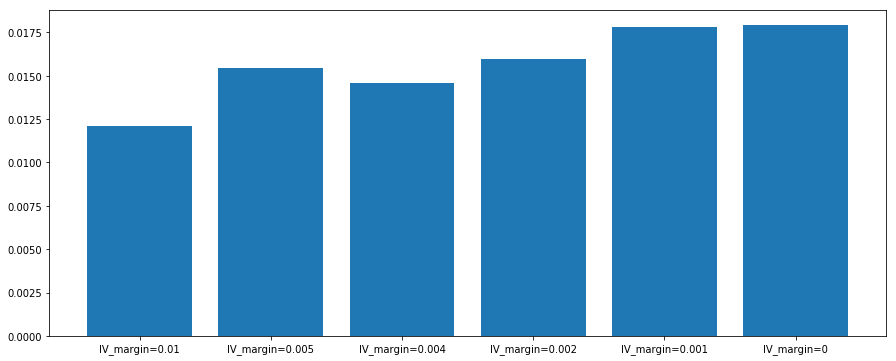

In [34]:
fig, ax = plt.subplots()

fig.set_figwidth(15)    
fig.set_figheight(6)    

ax.bar(models_gini['test'], models_gini['gini']-0.3)

In [35]:
drop_list = drop_list_sv.copy()
X = X_sv.copy()
X_woe = X_woe_sv.copy()
X_val = X_val_sv.copy()
wing = wng.WingsOfEvidence(bin_minimal_size=0.05, bin_size_increase=0.05, is_monotone=False)
wing.fit(X,Y)
X_woe = wing.transform(X)

log = LogisticRegression()
log.fit(X_woe, Y)

X_val_woe = wing.transform(X_val)
val_proba = log.predict_proba(X_val_woe)
PD = val_proba[:, 1]

### TEST 2

С помощью встроенного в пакет метода возможно получить рассчитать Gini в разрезей features модели 

In [36]:
gini = wing.get_gini_vector()


In [37]:
gini


purpose                   5.553808
addr_state                3.109353
sub_grade                14.324847
home_ownership            5.901128
dti                      12.294358
funded_amnt               9.548865
annual_inc               11.358496
emp_length                2.029067
term                     18.419967
inq_last_6mths            9.245112
mths_since_recent_inq     8.795356
delinq_2yrs               1.347955
num_accts_ever_120_pd     1.956238
num_tl_90g_dpd_24m        0.604011
acc_open_past_24mths     12.325030
avg_cur_bal              10.838504
tot_hi_cred_lim          10.375021
dtype: float64

Однако, поскольку метод вызывается обученным экземпляром модели WingsOfEvidence, который обучен на обучающей выборке, нет возможности посчитать Gini для валидирующей выборки. В связи с этим ниже представлена функция (написанная с использованием кода из пакета sberbank-ai/wing) для подсчёта Gini заданной feature на основе произвольной выборки.

In [38]:
def gini_factor(wing, X_val, Y_val, attr_name):
    #экземпляр модели WingOfEvidence атрибута attr_name, из которого можно извлечь классы разбиения WoE
    cur_wing = wing.fitted_wing[attr_name]
    cur_X = X_val[attr_name]
    
    #check_data собирает feature и Y в один датафрейм, переименовывает в Х и Y
    val_addr = cur_wing._check_data(cur_X, Y_val)
    
    #обработка NaN значений. При WoE трансформации они относятся к отдельному классу со своим весом.
    miss_X = val_addr[pd.isnull(val_addr["X"])].copy()
    miss_X["woe_group"] = "AUTO_MISS"
    
    #датасет без NaN, для значений которого будет происходить определение bucket
    flt_conc = ~pd.isnull(val_addr["X"])
    clear_val_addr = val_addr[flt_conc].copy()
    
    #vector_type - признак числовой или категориальной feature. 
    #Для числовых факторов buckets представляют из себя интервалы, optimal_edges - их границы, полученные после обучения.
    #Для категориальных факторов используется обученный DecisionTreeClassifier, являющийся частью модуля wing.
    if cur_wing.vector_type == "c":
        clear_val_addr["woe_group"] = wng.split_by_edges(clear_val_addr["X"], cur_wing.optimal_edges)
    else:
        transformed_X = cur_wing.discrete_onehot_enc.transform(
                    cur_wing.discrete_label_enc.transform(clear_val_addr["X"]).reshape(-1, 1))
        clear_val_addr["woe_group"] = cur_wing.discrete_binner.predict_proba(X=transformed_X)[:, 1]
    
    #склеиваем полученные bucket для NaN и не NaN
    full_transform = pd.concat([miss_X, clear_val_addr], axis=0)
    
    #Подсчитываем количество значений в каждом bucket
    agg = full_transform.groupby(["woe_group"]).size().reset_index(drop=False)
    agg.columns = ['woe_group', 'total']
    
    #Подсчитываем количество дефолтных значений в каждом bucket
    df1 = full_transform.pivot_table(index='woe_group', values='y', aggfunc='sum')
    agg['good'] = pd.Series(df1['y'].tolist())
    
    #Считаем количество недефолтных значений, а также процент дефолтных
    agg['bad'] = agg['total'] - agg['good']
    agg['local_event_rate'] = agg['good']/agg['total']
    agg = agg.sort_values(by="local_event_rate", ascending=False)
    
    #Перекодируем обозначение бакетов на значение самого интервала для численных факторов
    if cur_wing.vector_type == "c":
        interv_dict = cur_wing.optimal_edges_dict
        interv_dict['AUTO_MISS'] = 'AUTO_MISS'
        agg['woe_group_ind'] = agg['woe_group']
        agg['woe_group'] = [interv_dict[v] for v in agg['woe_group']]
    else:
        agg['woe_group_ind'] = agg['woe_group']
        
    #Для подсчёта gini фактора модели воспользуемся методом предоставленной библиотеки 
    gini_index_value = wng.gini_index(agg["good"].values, agg["bad"].values)
    return gini_index_value, agg

In [39]:
#С помощью написанного метода расчитаем gini для всех факторов модели на валидирующей выборке
gini_index = []

for col in X_val.columns:
    try:
        g, _ = gini_factor(wing, X_val, Y_val, col)
    except:
        g = 'Not in wing'
    gini_index.append([col, g])

gini_index_df = pd.DataFrame(columns = ['attr', 'gini'], data = gini_index)


Значения индексов Джини в процентах для факторов модели на валидационной выборке

In [40]:
gini_index_df.sort_values(by = 'gini', ascending = False)


,attr,gini
14,acc_open_past_24mths,16.035165
4,dti,15.404387
2,sub_grade,13.072942
8,term,12.500220
15,avg_cur_bal,12.175688
16,tot_hi_cred_lim,11.743719
6,annual_inc,11.471304
10,mths_since_recent_inq,10.304952
3,home_ownership,9.270922
9,inq_last_6mths,9.030557


График коэффициентов gini для факторов модели по убыванию

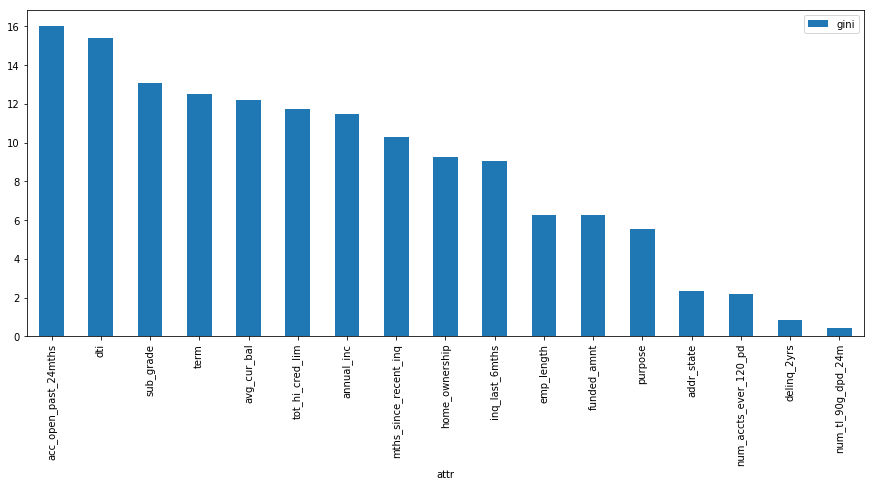

In [41]:
gini_index_df.query('gini != "Not in wing"').sort_values(by="gini", ascending = False).plot(kind='bar', figsize = [15, 6], x = 'attr')

Итого, у 4-х фичей на данный момент Gini менее 5%, что составляет 23% от общего количества факторов.

### TEST 3

Выделяем в датасете feature_index - индекс атрибута в обученном экземпляре класса wing.

In [42]:
features_sorted_gini = gini_index_df.query('gini != "Not in wing"').reset_index(drop=False).sort_values(by="gini", ascending = False)
features_sorted_gini.columns = ['feature_index', 'feature', 'gini']
features_sorted_gini = features_sorted_gini.reset_index(drop = True)

Ниже цикл, в котором производится подсчёт коэффициенты Джини для моделей, в которые добавляются факторы по возрастанию коэффициента Джини в разрезе фактора.

In [43]:
from copy import deepcopy

In [44]:
incr_gini=[]
incr_rocauc = []
for ind in features_sorted_gini.index:
    #выбираем индексы факторов, Джини которых меньше текущего
    cur_features = features_sorted_gini['feature_index'][ind+1:].tolist()
    #делаем копию обученной модели
    log_temp = deepcopy(log)
    #исключаем из модели влияние features с коэффициентом Джини меньше текущего
    log_temp.coef_[0][cur_features] = 0
    #расчёт PD с помощью урезанной модели, коэффициентов rocauc и Джини
    val_temp_proba = log_temp.predict_proba(X_val_woe)
    PD_temp = val_temp_proba[:, 1]
    rocauc = roc_auc_score(Y_val, PD_temp)
    gini = 2*rocauc - 1
    incr_gini.append(gini)
    incr_rocauc.append(rocauc)
    
features_sorted_gini['incr_gini'] = pd.Series(incr_gini)
#для подсчёта прироста коэффициента Джини с добавлением нового фактора в модель, добавляем список коэффициентов Джини
#второй раз со сдвигом
prev_incr_gini = [0] + incr_gini[:-1]
features_sorted_gini['prev_incr_gini'] = pd.Series(prev_incr_gini)  


Джини урезанных моделей представлены ниже:

In [45]:
features_sorted_gini

,feature_index,feature,gini,incr_gini,prev_incr_gini
0,14,acc_open_past_24mths,16.035165,0.160352,0.000000
1,4,dti,15.404387,0.200293,0.160352
2,2,sub_grade,13.072942,0.238252,0.200293
3,8,term,12.500220,0.245714,0.238252
4,15,avg_cur_bal,12.175688,0.257438,0.245714
5,16,tot_hi_cred_lim,11.743719,0.282253,0.257438
6,6,annual_inc,11.471304,0.294201,0.282253
7,10,mths_since_recent_inq,10.304952,0.301207,0.294201
8,3,home_ownership,9.270922,0.304996,0.301207
9,9,inq_last_6mths,9.030557,0.308499,0.304996


График вкладов факторов в формирование Джини модели

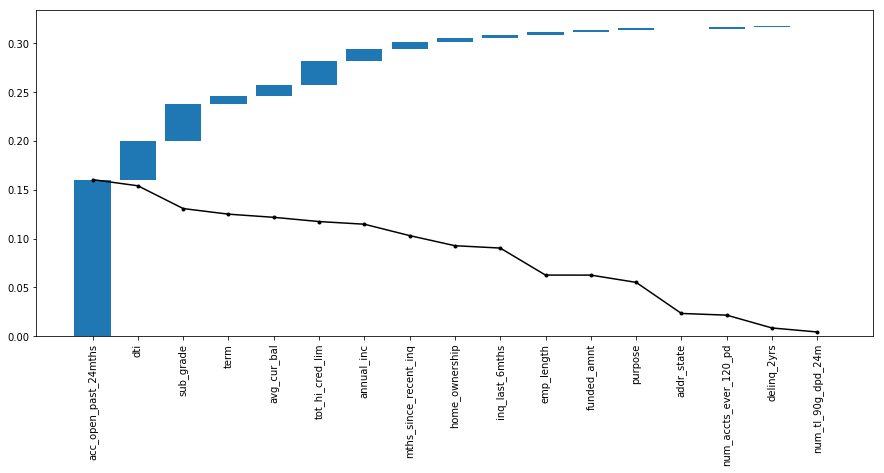

In [46]:
fig, ax = plt.subplots()

ax.bar(features_sorted_gini['feature'], features_sorted_gini['incr_gini'])
ax.bar(features_sorted_gini['feature'], features_sorted_gini['prev_incr_gini'], facecolor = 'white')
ax.plot(features_sorted_gini['gini']/100, color = 'black', marker = '.')
plt.xticks(rotation = 90)

fig.set_figwidth(15)
fig.set_figheight(6)

plt.show()

#### Исключение addr_state и num_tl_90g_dpd_24m 

На графике, видно, что аттрибут addr_state (как и предполагалось по итогу предыдущего анализа с Information Value), а также атрибут num_tl_90g_dpd_24m вносят отриацтельный вклад в индекс Джини. Посмотрим, как повлияет их исключение на итоговый Джини модели.

In [47]:
X.drop(['addr_state'],axis='columns', inplace=True)
X_val.drop(['addr_state'],axis='columns', inplace=True)
drop_list.append('addr_state')

In [48]:
wing = wng.WingsOfEvidence(bin_minimal_size=0.05, bin_size_increase=0.05, is_monotone=False)
wing.fit(X,Y)
X_woe = wing.transform(X)

log = LogisticRegression()
log.fit(X_woe, Y)

X_val_woe = wing.transform(X_val)
val_proba = log.predict_proba(X_val_woe)
PD = val_proba[:, 1]

rocauc = roc_auc_score(Y_val, PD)
gini = 2*rocauc - 1
gini_bord.append(gini)
border.append('-addr_state')
models_gini.loc[len(models_gini)] = {'test': '-addr_state', 'gini' : gini}

In [49]:
X.drop(['num_tl_90g_dpd_24m'],axis='columns', inplace=True)
X_val.drop(['num_tl_90g_dpd_24m'],axis='columns', inplace=True)
drop_list.append('num_tl_90g_dpd_24m')

In [50]:
wing = wng.WingsOfEvidence(bin_minimal_size=0.05, bin_size_increase=0.05, is_monotone=False)
wing.fit(X,Y)
X_woe = wing.transform(X)

log = LogisticRegression()
log.fit(X_woe, Y)

X_val_woe = wing.transform(X_val)
val_proba = log.predict_proba(X_val_woe)
PD = val_proba[:, 1]

rocauc = roc_auc_score(Y_val, PD)
gini = 2*rocauc - 1
gini_bord.append(gini)
border.append('-num_tl_90g_dpd_24m')
models_gini.loc[len(models_gini)] = {'test': '-num_tl_90g_dpd_24m', 'gini' : gini}

<BarContainer object of 8 artists>

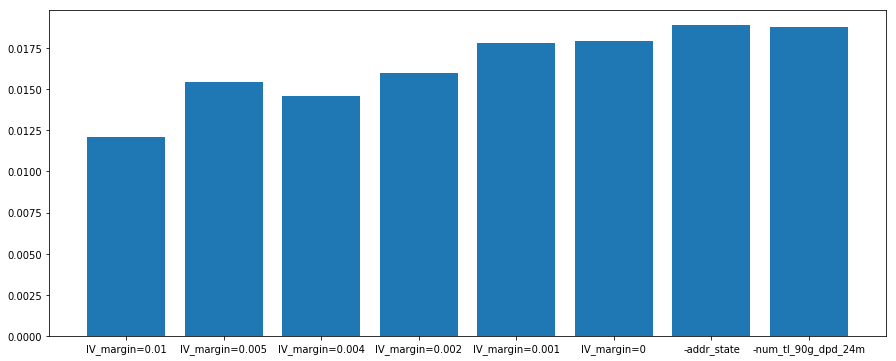

In [51]:
fig, ax = plt.subplots()
fig.set_figwidth(15)    
fig.set_figheight(6)    
ax.bar(models_gini['test'], models_gini['gini']-0.3)


Таким образом, исключение addr_state даёт значительный прирост Gini. Исключение num_tl_90g_dpd_24m немного ухудшает Gini, однако незначительно. Для красоты остальных метрик оставим, как есть.

#### Test 2-3 после дополнительного усечения модели

Коэффициент Gini модели составляет 31.88%

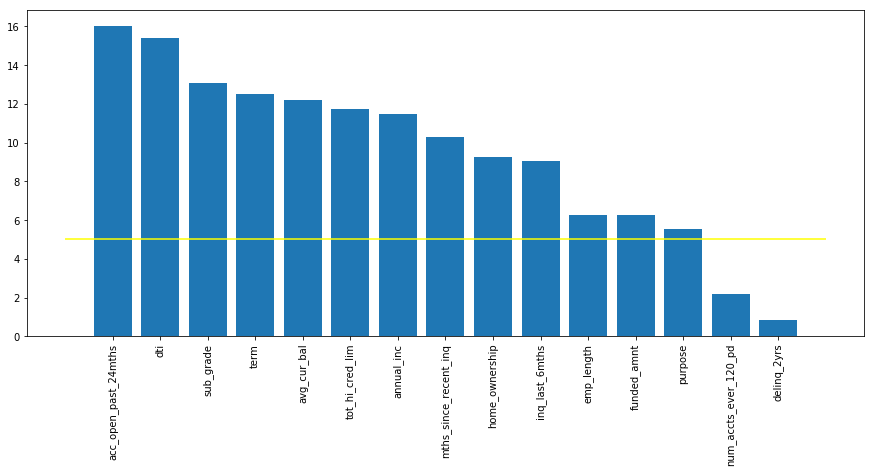

In [52]:
gini_index_df = gini_index_df.drop(gini_index_df[(gini_index_df['attr'] == 'addr_state')].index)
gini_index_df = gini_index_df.drop(gini_index_df[(gini_index_df['attr'] == 'num_tl_90g_dpd_24m')].index).sort_values(by='gini', ascending = False)

fig, ax = plt.subplots()

ax.bar(gini_index_df['attr'], gini_index_df['gini'])
plt.xticks(rotation = 90)
ax.hlines(y=5, xmin = -1, xmax = 15, color='yellow', alpha=1)

fig.set_figwidth(15)    
fig.set_figheight(6)    

У 2-х фичей на данный момент Gini менее 5%, что составляет 13% от общего количества факторов.

In [53]:
gini_index_df = gini_index_df.sort_index()
gini_index_df = gini_index_df.reset_index(drop = True)
features_sorted_gini = gini_index_df.reset_index(drop=False).sort_values(by="gini", ascending = False)
features_sorted_gini.columns = ['feature_index', 'feature', 'gini']
features_sorted_gini = features_sorted_gini.reset_index(drop=True)

In [54]:
incr_gini=[]
incr_rocauc = []
for ind in features_sorted_gini.index:
    #выбираем индексы факторов, Джини которых меньше текущего
    cur_features = features_sorted_gini['feature_index'][ind+1:].tolist()
    #делаем копию обученной модели
    log_temp = deepcopy(log)
    #исключаем из модели влияние features с коэффициентом Джини меньше текущего
    log_temp.coef_[0][cur_features] = 0
    #расчёт PD с помощью урезанной модели, коэффициентов rocauc и Джини
    val_temp_proba = log_temp.predict_proba(X_val_woe)
    PD_temp = val_temp_proba[:, 1]
    rocauc = roc_auc_score(Y_val, PD_temp)
    gini = 2*rocauc - 1
    incr_gini.append(gini)
    incr_rocauc.append(rocauc)
    
features_sorted_gini['incr_gini'] = pd.Series(incr_gini)
#для подсчёта прироста коэффициента Джини с добавлением нового фактора в модель, добавляем список коэффициентов Джини
#второй раз со сдвигом
prev_incr_gini = [0] + incr_gini[:-1]
features_sorted_gini['prev_incr_gini'] = pd.Series(prev_incr_gini)  


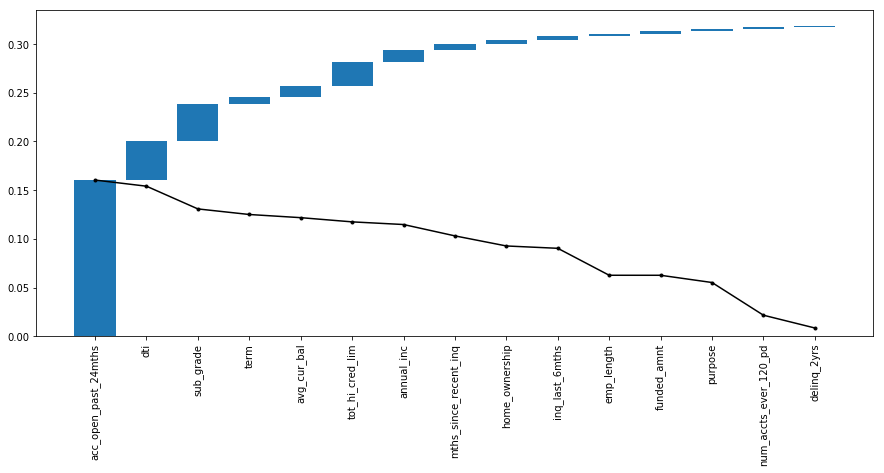

In [55]:
fig, ax = plt.subplots()

ax.bar(features_sorted_gini['feature'], features_sorted_gini['incr_gini'])
ax.bar(features_sorted_gini['feature'], features_sorted_gini['prev_incr_gini'], facecolor = 'white')
ax.plot(features_sorted_gini['gini']/100, color = 'black', marker = '.')
plt.xticks(rotation = 90)

fig.set_figwidth(15)
fig.set_figheight(6)

plt.show()

После удаления атрибутов график для test 3 выглядит таким образом

### TEST 4

In [56]:
import numpy.random as npr

In [57]:
X_val_dt = pd.DataFrame(X_val_dt)

Функция bootstarp для подсчёта доверительного интервала индекса джини. Входные пар-ры: фактический дефолт и вероятность входа в дефолт, список индексов партиции, для которой подсчитывается доверительный интервал, и объём формуируемой bootstrap-ом выборки.

In [58]:

def bootstrap(Y_val, PD, indexes, n_iter):
    num_samples = len(indexes)
    gini_btstr = []
    for j in range(n_iter):
        idx = [indexes[i] for i in npr.randint(0, num_samples-1, num_samples)]
        rocauc = roc_auc_score(Y_val[idx], PD[idx])
        gini = 2*rocauc -1
        gini_btstr.append(gini*100)
    return gini_btstr

In [60]:
#!!!!!!код выполняется около 20 минут (вполне допускаю, можно было написать оптимальнее)
dates = X_val_dt['issue_d'].unique()
gini_per_dt = []
len_per_dt = []
gini_lower_CI95 = []
gini_higher_CI95 = []
gini_lower_CI95_ = []
gini_higher_CI95_ = []
#цикл для подсчёта метрик для подвыборок в разрезе даты
for dt in dates:
    cur_indexes = X_val_dt.query('issue_d == @dt').index
    len_per_dt.append(len(cur_indexes))
    rocauc = roc_auc_score(Y_val[cur_indexes], PD[cur_indexes])
    gini = 2*rocauc - 1
    gini_per_dt.append(gini*100)
    print(dt)
    cur_indexes = cur_indexes.tolist()
    gini_btstr = bootstrap(Y_val, PD, cur_indexes, 5000)
    gini_lower_CI95.append(np.percentile(gini_btstr, 2.5))
    gini_higher_CI95.append(np.percentile(gini_btstr, 97.5))
    CI = mean_confidence_interval(gini_btstr)


2015-04-01
2014-09-01
2014-10-01
2014-07-01
2015-01-01
2014-12-01
2015-05-01
2014-06-01
2014-11-01
2015-03-01
2014-08-01
2015-02-01


Ниже представлена динамика коэффициента Джини модели в разрезе наборов данных, разделённых по датам. Из графика видно, что отсутствуют значительные провалы в ранжирующей способности модели.

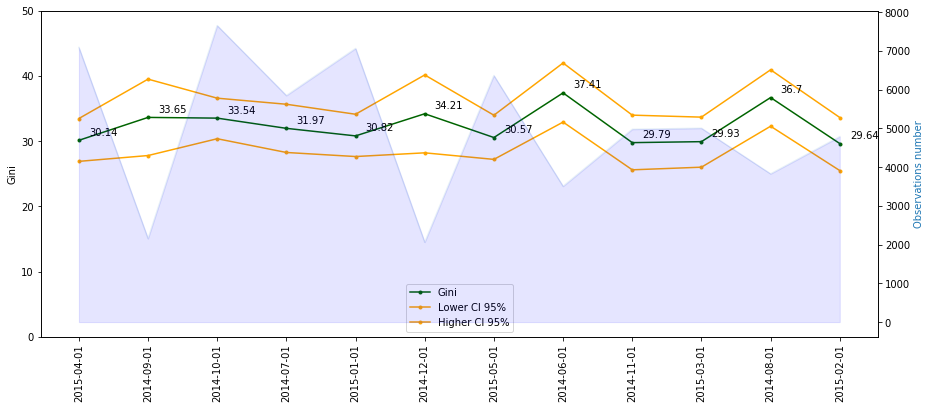

In [61]:
fig, ax = plt.subplots()

fig.set_figwidth(15)    
fig.set_figheight(6)    

ax.plot(dates, gini_per_dt, marker = '.', color = 'darkgreen', label = 'Gini')
ax.plot(dates, gini_lower_CI95, marker = '.', color = 'orange', label = 'Lower CI 95%')
ax.plot(dates, gini_higher_CI95, marker = '.', color = 'orange', label = 'Higher CI 95%')
ax.set_ylabel('Gini')
plt.ylim([0,50])
#ax1.set_ylabel('exp', color=color)
plt.xticks(rotation = 90)
for i in range(len(gini_per_dt)):
    ax.annotate( str(round(gini_per_dt[i], 2)), (dates[i], gini_per_dt[i]),  xytext=(10,5), textcoords='offset points')

ax2 = ax.twinx()
color = 'tab:blue'
ax2.set_ylabel('Observations number', color=color)  
ax2.plot(dates, len_per_dt, color=color, alpha = 0.1)
ax2.fill_between(dates, len_per_dt, color = 'blue', alpha=0.1, label = 'Observations number')
ax.legend(loc = 'lower center')

plt.show()


#### TEST 5

Ниже представлен анализ качества woe-преобразования и сохранение монотонности.
Общая линия тренда для всех атрибутов сохраняется. Практически для всех woe-преобразований есть нарушения монотонности, однако никакие из них не перешли за черту красного светофора, т.е. либо превышение < 10%, либо объём бакета с нарушением монотонности составляет менее 10% от выборки. Судя по всему, вторая ситуация происходит чаще, поскольку для численных переменных наблюдается большое количество бакетов с более менее равномерным распределением записей по бакетам.

In [62]:
features = X_val.columns

В коде мы пользуемся теми же таблицами со статистикой по атрибуту, рассчитываемыми с помощью нашей функции gini_factor для валидационной выборки и get_wing_agg() для тренировочной. Local_event_rate - необходимый нам уровень дефолта, по которому мы отслеживаем монотонность. Total - количество измерений в бакете, сравниваем между собой.

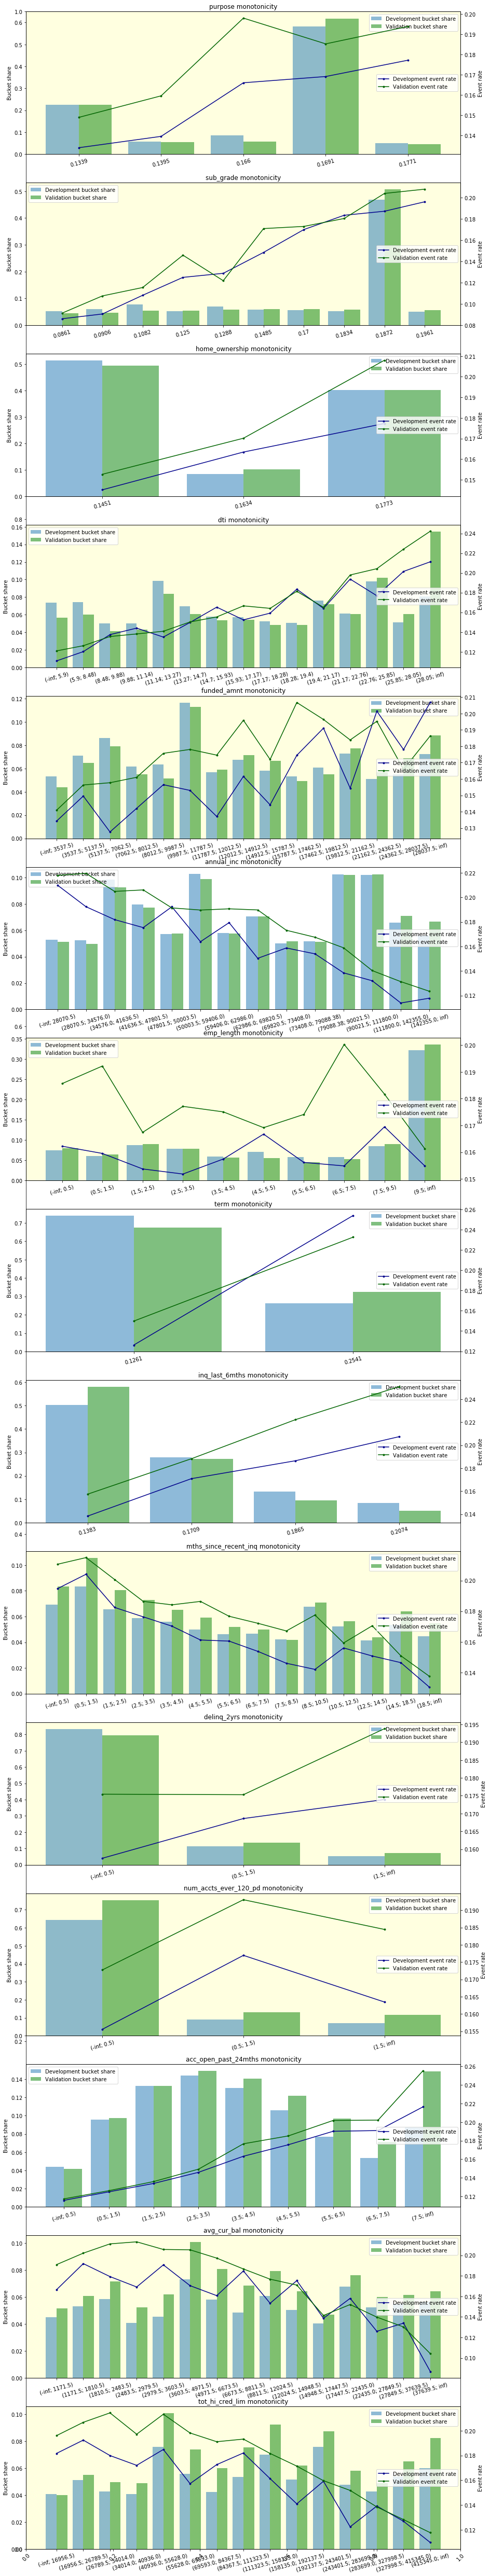

In [63]:
fig = plt.figure()

fig.set_figwidth(15)    #  ширина Figure
fig.set_figheight(6*len(features))    #  высота Figure


for i, col in enumerate(features):
    _, wing_agg_val = gini_factor(wing, X_val, Y_val, col)
    wing_agg = wing.fitted_wing[col].get_wing_agg()
    wing_agg_val = wing_agg_val.query('woe_group != "AUTO_MISS"').sort_values(by="woe_group_ind")
    
    plt.xticks(rotation = 45)
    
    ax = fig.add_subplot(len(features),1,i+1)
    ax.set_ylabel('Bucket share')
    buckets = []
    for buck in wing_agg.index.tolist():
        if wing.fitted_wing[col].vector_type == "c":
            buck = '('+str(round(buck[0], 2))+ '; '+ str(round(buck[1], 2)) + ')' #передаём в виде "тиков" интервал в виде строки
        else:
            buck = str(round(buck, 4))
        buckets.append(buck)
    x = np.arange(len(buckets)) #нумеруем бакеты для построения графиков объёмов выборки
    ax.bar(x-0.2, wing_agg['total']/len(X), width = 0.4, alpha = 0.5, label = 'Development bucket share')
    ax.bar(x+0.2, wing_agg_val['total']/len(X_val), width = 0.4, alpha = 0.5, color = 'green', label = 'Validation bucket share')
    ax2 = ax.twinx()
    ax2.set_ylabel('Event rate') 
    ax2.plot(buckets, wing_agg['local_event_rate'], marker = '.', color = 'darkblue', label = 'Development event rate')
    ax2.plot(buckets, wing_agg_val['local_event_rate'], marker = '.', color = 'darkgreen', label = 'Validation event rate')
    
    #светофор для графика
    buckets = wing_agg.index.tolist()
    buckets_val = wing_agg_val.index.tolist()
    for i in range(len(buckets)-1):
        TR_i, TR_ii = wing_agg['local_event_rate'][buckets[i]], wing_agg['local_event_rate'][buckets[i+1]]
        TR_i_val, TR_ii_val = wing_agg_val['local_event_rate'][buckets_val[i]], wing_agg_val['local_event_rate'][buckets_val[i+1]]
        #расчёт относительного прироста следующего бакета к текущему
        inc_mntn = (TR_ii - TR_i)/TR_i
        inc_mntn_val = (TR_ii_val - TR_i_val)/TR_i_val
        #если тренд возрастающий, изменим знак относительного прироста (вместо изменения знака неравенства в проверке условий)
        if wing_agg['local_event_rate'][buckets[0]] < wing_agg['local_event_rate'][buckets[-1]]:
            inc_mntn *= -1
            inc_mntn_val *= -1
            
        if (inc_mntn >= 0.1 and wing_agg['total'][buckets[i+1]]/len(X) > 0.1) or \
        (inc_mntn_val >= 0.1 and wing_agg_val['total'][buckets_val[i+1]]/len(X_val) > 0.1):
            ax.set_facecolor(color = 'lightpink') #относительный прирост превысил 0.1 и объём в бакете больше 0.1 от выборки
        elif (inc_mntn >= 0.1 and wing_agg['total'][buckets[i+1]]/len(X) < 0.1) or \
        (inc_mntn_val >= 0.1 and wing_agg_val['total'][buckets_val[i+1]]/len(X_val) < 0.1) or \
        (inc_mntn > 0 and inc_mntn < 0.1 and wing_agg['total'][buckets[i+1]]/len(X) >= 0.1) or \
        (inc_mntn_val > 0 and inc_mntn_val < 0.1 and wing_agg_val['total'][buckets_val[i+1]]/len(X_val) >= 0.1):
            ax.set_facecolor(color = 'lightyellow')

    for tick in ax.get_xticklabels():
        tick.set_rotation(15)
    ax.legend()
    ax2.legend(loc = 'right')
    plt.title(col + ' monotonicity')
    

### TEST 6

В данном простом тесте сравним среднее прогнозное значение наступления дефолта с уровнем дефолта по всей выборке. Для PD построим также доверительные интервалы.

In [96]:
PD_mean = np.mean(PD)
TR = np.mean(Y_val)
P_mean_95 = (np.percentile(PD, 2.5), np.percentile(PD, 97.5))
P_mean_99 = (np.percentile(PD, 0.5), np.percentile(PD, 99.5))
#P_mean_95 = mean_confidence_interval(PD)
#P_mean_99 = mean_confidence_interval(PD, confidence = 0.99)


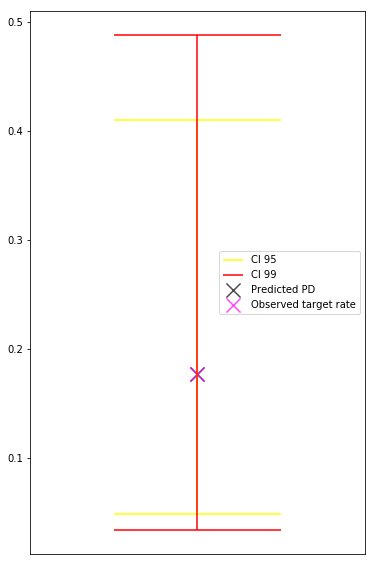

In [97]:
fig, ax = plt.subplots()
fig.set_figheight(10)    #  высота Figure
plt.xlim([30,70])
ax.vlines(x=50, ymin=P_mean_95[0], ymax=P_mean_95[1], color='yellow', alpha=1, label = 'CI 95')
ax.hlines(y=P_mean_95[0], xmin=40, xmax=60, color='yellow', alpha=1)
ax.hlines(y=P_mean_95[1], xmin=40, xmax=60, color='yellow', alpha=1)
ax.vlines(x=50, ymin=P_mean_99[0], ymax=P_mean_99[1], color='red', alpha=1, label = 'CI 99')
ax.hlines(y=P_mean_99[0], xmin=40, xmax=60, color='red', alpha=1)
ax.hlines(y=P_mean_99[1], xmin=40, xmax=60, color='red', alpha=1)
ax.scatter(y=PD_mean, x=50, s=200, color='black', alpha=0.7, marker = 'x', label = 'Predicted PD')
ax.scatter(y=TR, x=50, s=200, color='magenta', alpha=0.7, marker = 'x', label = 'Observed target rate')
ax.axes.get_xaxis().set_visible(False)
ax.legend(loc = 'right')


In [66]:
#светофор:
print((TR - PD_mean) / TR)

-0.00032180784984739


Имеем отклонение фактического уровня целевого события от среднего прогнозного на валидационной выборке, соответствующее жёлтому светофору.

### TEST 7

Рассчитаем тест аналогично тесту 6 в разрезе значений скорингового балла, полученного перемножением коэффициентов модели и преобразованных woe-значений. 

In [67]:
coef = log.coef_
score = np.matmul(np.array(X_val_woe), coef.T) #матрично перемножаем woe-значения и коэффициенты модели


In [68]:

Y_val = pd.DataFrame(Y_val)
Y_val['lazy_score'] = pd.Series(score[:,0])

Y = pd.DataFrame(Y)
Y['lazy_score'] = pd.Series(np.matmul(np.array(X_woe), log.coef_.T)[:,0])

#пустые списки для подсчёта количества измерений в бакете, среднего PD, уровня дефолта в бакете, границ доверительного интервала PD
value, PD_sc, TR_sc, P_mn_95_sc_hr, P_mn_95_sc_lr, P_mn_99_sc_hr, P_mn_99_sc_lr = [],[],[],[],[],[],[]
metrics = []

step=0.3 #шаг для разделения бакетов выборки по скору
for s in np.arange(-1.8, 1.8, step):

    if s == -1.8: #крайний левый интервал
        cur_indexes_val = Y_val.query('lazy_score < @s+@step').index
        #cur_indexes = Y.query('lazy_score < @s+@step').index
    elif s == 1.5: #крайний правый интервал
        cur_indexes_val = Y_val.query('lazy_score >= @s').index
        #cur_indexes = Y.query('lazy_score >= @s').index
    else:
        cur_indexes_val = Y_val.query('lazy_score >= @s and lazy_score < @s+@step').index
        #cur_indexes = Y.query('lazy_score >= @s and lazy_score < @s+@step').index
    
    PD_mean = np.mean(PD[cur_indexes_val])
    TR = np.mean(Y_val.iloc[cur_indexes_val]['def'])
    P_mean_95 = (np.percentile(PD[cur_indexes_val], 2.5), np.percentile(PD[cur_indexes_val], 97.5))
    P_mean_99 = (np.percentile(PD[cur_indexes_val], 0.5), np.percentile(PD[cur_indexes_val], 99.5))
    #P_mean_95 = mean_confidence_interval(PD[cur_indexes_val])
    #P_mean_99 = mean_confidence_interval(PD[cur_indexes_val], confidence = 0.99)
    
    value.append(len(cur_indexes_val))
    PD_sc.append(PD_mean)
    TR_sc.append(TR)
    P_mn_95_sc_hr.append(P_mean_95[1])
    P_mn_95_sc_lr.append(P_mean_95[0])
    
    P_mn_99_sc_hr.append(P_mean_99[1])
    P_mn_99_sc_lr.append(P_mean_99[0])
    #расчёт оценки теста, относительное отклонение уровня целевого события от среднего прогноза 
    metrics.append(abs(TR - PD_mean) / TR) 
    


На графике видим, что для большего объёма выборки (средние бакеты) фактический уровень события дефолта попадает в 95% доверительный интервал прогнозного значения. Для бакетов с низким скором наблюдается относительно высокое расхождение.

['(-inf; -1.5]', '(-1.5;-1.2]', '(-1.2;-0.9]', '(-0.9;-0.6]', '(-0.6;-0.3]', '(-0.3;0.0]', '(0.0;0.3]', '(0.3;0.6]', '(0.6;0.9]', '(0.9;1.2]', '(1.2;1.5]', '(1.5; inf)']


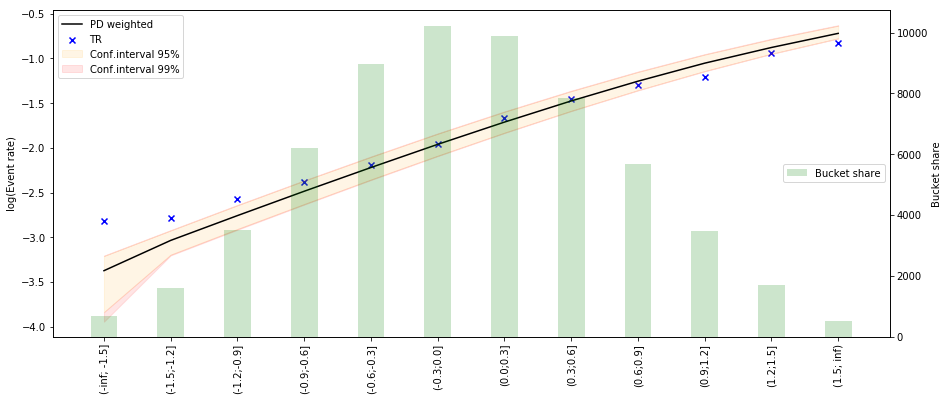

In [69]:
fig, ax = plt.subplots()

fig.set_figwidth(15)    
fig.set_figheight(6)    

xticks = ['(-inf; -1.5]']
xticks.extend(['('+str(round(a-0.3,1))+';'+str(round(a,1))+']' for a in np.arange(-1.2, 1.8, 0.3)])
xticks.append('(1.5; inf)')
print(xticks)

ax.plot(xticks, np.log(PD_sc), color = 'black', label = 'PD weighted')
ax.scatter(xticks, np.log(TR_sc), marker='x', color = 'blue', label = 'TR')
#ax.plot(xticks, np.log(P_mn_95_sc_hr),  color = 'orange', label = 'Lower CI 95%')
#ax.plot(xticks, np.log(P_mn_95_sc_lr),  color = 'orange', label = 'Higher CI 95%')
#ax.plot(xticks, np.log(P_mn_99_sc_hr),  color = 'red', label = 'Lower CI 99%')
#ax.plot(xticks, np.log(P_mn_99_sc_lr),  color = 'red', label = 'Higher CI 99%')

ax.fill_between(xticks, np.log(P_mn_95_sc_hr), np.log(P_mn_95_sc_lr), color = 'orange', alpha=0.1, label = 'Conf.interval 95%')
ax.fill_between(xticks, np.log(P_mn_95_sc_hr), np.log(P_mn_99_sc_hr), color = 'red', alpha=0.1, label = 'Conf.interval 99%')
ax.fill_between(xticks, np.log(P_mn_99_sc_lr), np.log(P_mn_95_sc_lr), color = 'red', alpha=0.1)
ax.set_ylabel('log(Event rate)')
#plt.ylim([0,50])

plt.xticks(rotation = 90)

ax2 = ax.twinx()
ax2.bar(xticks, value, color = 'green', alpha = 0.2, width = 0.4, label = 'Bucket share')
ax2.set_ylabel('Bucket share')  

ax.legend()
ax2.legend(loc = 'right')

plt.show()


Ниже расчёт светофора для теста. Для всех бакетов относительное отклонение уровня целевого события от среднего PD меньше 20%.

In [70]:
sum([1 if d>0.2 else 0 for d in metrics])/len(metrics)

0.16666666666666666

#### TEST 8

In [71]:
Y_val = Y_val['def'].copy() 
Y = Y['def'].copy()

Рассчитаем коэффициенты Джини для обучающей и валидационной выборки.

In [72]:
rocauc = roc_auc_score(Y_val, PD)
gini_val = 2*rocauc - 1

dev_proba = log.predict_proba(X_woe)
PD_dev = dev_proba[:, 1]
rocauc_dev = roc_auc_score(Y,PD_dev)
gini_dev = 2*rocauc_dev - 1


Воспользуемся написанной ранее функцией для подсчёта bootstrapped CI индекса Джини.

In [73]:
#!!!код работает 30-40 минут, нужна оптимизация
ginis_dev = bootstrap(Y, PD_dev, Y.index.tolist(), 5000)
ginis_val = bootstrap(Y_val, PD, Y_val.index.tolist(), 5000)

In [89]:
CI_ginis_dev_ = (np.percentile(ginis_dev, 2.5), np.percentile(ginis_dev, 97.5))
CI_ginis_val_ = (np.percentile(ginis_val, 0.5), np.percentile(ginis_val, 99.5))


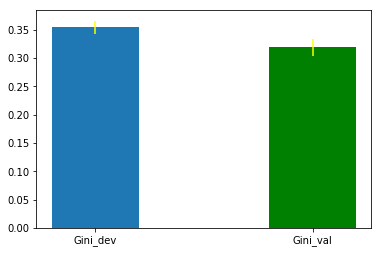

In [95]:
fig, ax = plt.subplots()

ax.bar('Gini_dev', gini_dev, width = 0.4)
ax.bar('Gini_val', gini_val, width = 0.4, color = 'green')
ax.vlines(x='Gini_dev', ymin=CI_ginis_dev_[0]/100, ymax=CI_ginis_dev_[1]/100, color='yellow', alpha=1)
ax.vlines(x='Gini_val', ymin=CI_ginis_val_[0]/100, ymax=CI_ginis_val_[1]/100, color='yellow', alpha=1)



Зелёный светофор теста: относительное снижение менее 15%

In [76]:
print('Абсолютное снижение: ', round(gini_dev-gini_val, 2))
print('Относительное снижение: ', round((gini_dev-gini_val)/gini_dev, 2))

Абсолютное снижение:  0.04
Относительное снижение:  0.1


####  TEST 9

In [77]:
features_gini_val = features_sorted_gini #воспользуемся предрасчитанной ранее статистикой по фичам 
gini_feat_dev = wing.get_gini_vector()


In [78]:
#объединим информацию по фичам в одном датафрейме. Рассчитаем абсолютное и относительное снижение gini.
gini_analytics = features_gini_val[['feature', 'gini']].copy()
gini_analytics = gini_analytics.rename(columns={'gini':'gini_val'})
gini_analytics['gini_dev'] = [gini_feat_dev[f] for f in features_gini_val['feature']]
gini_analytics['gini_delta'] = (gini_analytics['gini_dev'] - gini_analytics['gini_val'])
gini_analytics['gini_d_relative'] = (gini_analytics['gini_dev'] - gini_analytics['gini_val'])/gini_analytics['gini_dev']

gini_analytics



,feature,gini_val,gini_dev,gini_delta,gini_d_relative
0,acc_open_past_24mths,16.035165,12.325030,-3.710136,-0.301024
1,dti,15.404387,12.294358,-3.110029,-0.252964
2,sub_grade,13.072942,14.324847,1.251905,0.087394
3,term,12.500220,18.419967,5.919746,0.321377
4,avg_cur_bal,12.175688,10.838504,-1.337185,-0.123374
5,tot_hi_cred_lim,11.743719,10.375021,-1.368698,-0.131922
6,annual_inc,11.471304,11.358496,-0.112808,-0.009932
7,mths_since_recent_inq,10.304952,8.795356,-1.509596,-0.171636
8,home_ownership,9.270922,5.901128,-3.369794,-0.571042
9,inq_last_6mths,9.030557,9.245112,0.214555,0.023207


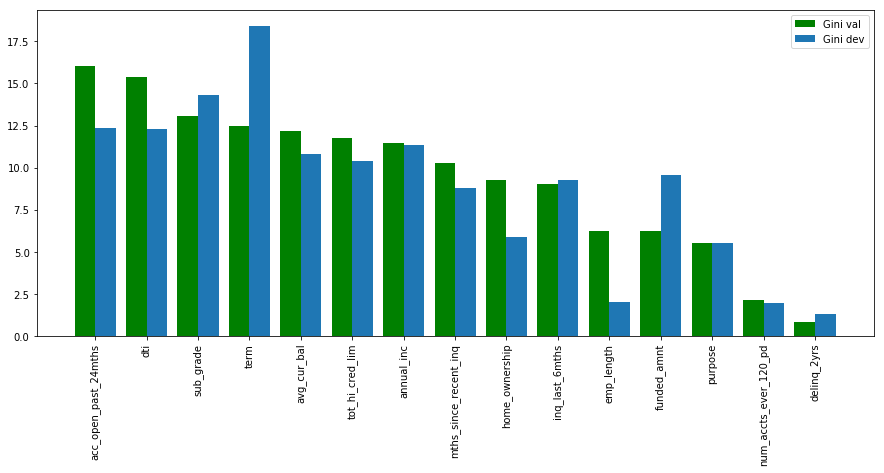

In [79]:
fig, ax = plt.subplots()
fig.set_figwidth(15)    
fig.set_figheight(6)    

x = np.arange(len(features_gini_val['feature']))
plt.xticks(x,features_gini_val['feature'], rotation = 90)
ax.bar(x-0.2, features_gini_val['gini'], width = 0.4, color = 'green', label = 'Gini val')
ax.bar(x+0.2, [gini_feat_dev[f] for f in features_gini_val['feature']], width = 0.4, label = 'Gini dev')
ax.legend()


Картина на этом тесте крайне плохая. Для многих фичей gini на обучающей выборки меньше gini на тестовой выборке. Помимо этого, есть относительные снижения более, чем на 20%: term, funded_amnt, delinq_2yrs.

Разобраться, почему так происходит, у меня, к сожалению, не осталось времени =(

Светофор теста: красный

#### Optimization task

Проведём небольшую симуляцию работы модели. Для этого положим, что все клиенты в обучающей/валидационной выборке взяли кредит суммой 100000 у.е под 7%. В случае, если кредит недефолтный, банк получает прибыль в размере 0.07*100000. Иначе рассчитаем два случая: test1 - банк теряет всю сумму при дефолте, test2sv - банк теряет 80% суммы при дефолте.

Найдём оптимальный порог отсечения для PD, при котором банк получает прибыль. Для этого переберём пороги отсечения с шагом 0.05

In [80]:
step=0.05 #пороги отсечения
opt_task = pd.DataFrame(np.arange(0, 1.003, step), columns = ['ticks'])


In [81]:
#тест на валидационной выборке
loan_amount = 100000
rate = 0.07
sv_rate = 0.8
step = 0.05
profit_, profit_sv = [], []
#в цикле рассчитываем прибыль для перебора пороговых значений
for dflt_thres in np.arange(0, 1.003, step):
    cur_profit, cur_profit2 = 0, 0
    for i in range(len(Y_val)):
        if PD[i] < dflt_thres:
            if Y_val[i] == 1:
                cur_profit -= loan_amount
                cur_profit2 -= loan_amount*sv_rate
            else:
                cur_profit += loan_amount*rate
                cur_profit2 += loan_amount*rate

    profit_.append(cur_profit)
    profit_sv.append(cur_profit2)


In [82]:
opt_task['test1_val']=pd.Series(profit_)
opt_task['test2sv_val']=pd.Series(profit_sv)


In [83]:
#тест на обучающей выборке
loan_amount = 100000
rate = 0.07
sv_rate = 0.8
step = 0.05
profit_, profit_sv = [], []
#separate thresholds
for dflt_thres in np.arange(0, 1.003, step):
    cur_profit, cur_profit2 = 0, 0
    for i in range(len(Y)):
        if PD_dev[i] < dflt_thres:
            if Y[i] == 1:
                cur_profit -= loan_amount
                cur_profit2 -= loan_amount*sv_rate #расчёт ситуации, когда банк теряет 80% суммы кредита при дефолте
            else:
                cur_profit += loan_amount*rate #прибыль
                cur_profit2 += loan_amount*rate
    #print(cur_profit)
    profit_.append(cur_profit)
    profit_sv.append(cur_profit2)
    

In [84]:
opt_task['test1_dev']=pd.Series(profit_)
opt_task['test2sv_dev']=pd.Series(profit_sv)


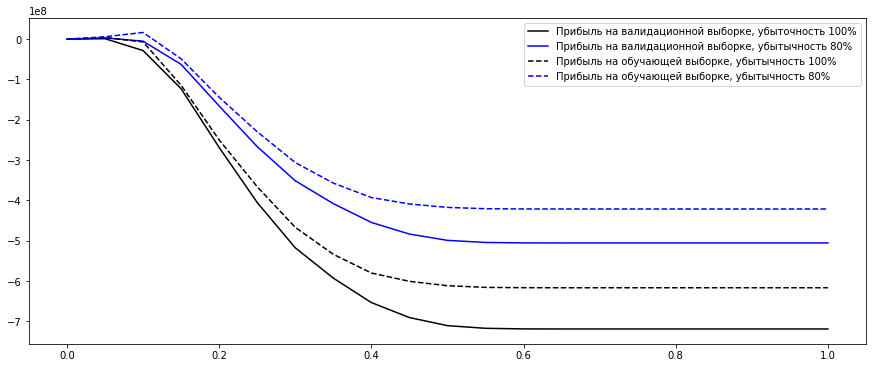

In [85]:
fig, ax = plt.subplots()
profit_ = pd.Series(profit_)
ax.plot(opt_task['ticks'], opt_task['test1_val'], color = 'black', label = 'Прибыль на валидационной выборке, убыточность 100%')
ax.plot(opt_task['ticks'], opt_task['test2sv_val'], color = 'blue', label = 'Прибыль на валидационной выборке, убытычность 80%')

ax.plot(opt_task['ticks'], opt_task['test1_dev'], color = 'black', ls = '--', label = 'Прибыль на обучающей выборке, убытычность 100%')
ax.plot(opt_task['ticks'], opt_task['test2sv_dev'], color = 'blue', ls = '--', label = 'Прибыль на обучающей выборке, убытычность 80%')
ax.legend()

fig.set_figwidth(15)    
fig.set_figheight(6)    

plt.show()


Как оказалось, разработанная модель не может обеспечить высокий уровень прибыли для банка.
Работа без убытка получается в районе PD = 0.05. Хотя проведённые тесты показывали среднее качество модели. 

Стоит отметить, что тесты оценивали работу модели в целом (т.е. как учёт правильно определённых недефолтов, так и дефолтов). В данной имитации оказывается гораздо важнее для модели делать как можно меньше ошибок в определении именно дефолта (т.е. имитация была бы гораздо выше при меньшем количистве метрики False Positive).

Таким образом, необходима работа над улучшением качества модели. Также, как вариант, можно попробовать при обучении рассмотреть функцию ошибок, которая штрафовала бы при False Positive гораздо больше, чем при False Negative. 

In [86]:
opt_task


,ticks,test1_val,test2sv_val,test1_dev,test2sv_dev
0,0.00,0.0,0.0,0.0,0.0
1,0.05,1125000.0,3105000.0,4041000.0,5981000.0
2,0.10,-28301000.0,-5061000.0,-6758000.0,16582000.0
3,0.15,-123063000.0,-62623000.0,-114555000.0,-48755000.0
4,0.20,-268613000.0,-165693000.0,-249843000.0,-144083000.0
5,0.25,-405123000.0,-266543000.0,-365978000.0,-229578000.0
6,0.30,-517325000.0,-351105000.0,-466620000.0,-305900000.0
7,0.35,-592485000.0,-407845000.0,-533485000.0,-356865000.0
8,0.40,-653107000.0,-454447000.0,-579839000.0,-392719000.0
9,0.45,-690310000.0,-483270000.0,-600483000.0,-408663000.0
